In this file we predict the future prediction of the navier stokes equation from the previous frames

In [125]:
from phi.flow import *
import numpy as np
from phi.field import curl
from tqdm.notebook import trange
import sys
sys.path.insert(1, r'C:\\Users\\onurb\\master\\PRJ_4ID22_TP\\2D-Turbulence-Python\\src')
sys.path.insert(2, r'C:\\Users\\onurb\\master\\PRJ_4ID22_TP\\codes')
from field import TaylorGreen,L2,Linf,McWilliams, TaylorGreen
from fluid import Fluid
from model_with_convolution1D import *
from DataGenerator import *
import matplotlib.pyplot as plt

In [126]:
#model parameters
domain = Box(x=64, y=64)  # Define the simulation grid size
DOMAIN = dict(x=64, y=64)
frame_number = 40
block_size = 8
dt = 0.5  # Time step size

In [127]:
def generate_initial_field():
    flow = Fluid(64, 64, Re=100.)
    flow.init_solver()
    flow.init_field(McWilliams)

    u, v = flow.get_vel()

    #velocity to staggered grid
    u_tensor = tensor(u, spatial('x,y'))
    v_tensor = tensor(v, spatial('x,y'))
    v0 = StaggeredGrid(math.stack([u_tensor, v_tensor], dual(vector='x,y')), extrapolation.PERIODIC)

    v0, _ = fluid.make_incompressible(v0, (), Solve('CG', 1e-3, x0=None)) #to ensure divergence free field we make it incompressable
    return v0

In [128]:
#with iteration faster
@jit_compile
def step(v, dt):
    v = advect.semi_lagrangian(v, v, dt=dt)
    v, _ = fluid.make_incompressible(v, (), Solve('CG', 1e-3, x0=None))
    return v

#generate multiple simulation with diffrent intial state
trj_list = []
v0 = generate_initial_field()
#plot(curl(v0))
v_trj = iterate(step, batch(time=frame_number), v0,dt=dt, range=trange, substeps=1)
trj_list.append(v_trj)


c:\Users\onurb\anaconda3\envs\cuda\Lib\site-packages\phiml\math\_optimize.py:631: UserWarning: Possible rank deficiency detected. Matrix might be singular which can lead to convergence problems. Please specify using Solve(rank_deficiency=...).
  warnings.warn("Possible rank deficiency detected. Matrix might be singular which can lead to convergence problems. Please specify using Solve(rank_deficiency=...).")


  0%|          | 0/40 [00:00<?, ?it/s]

c:\Users\onurb\anaconda3\envs\cuda\Lib\site-packages\phiml\math\_optimize.py:631: UserWarning: Possible rank deficiency detected. Matrix might be singular which can lead to convergence problems. Please specify using Solve(rank_deficiency=...).
  warnings.warn("Possible rank deficiency detected. Matrix might be singular which can lead to convergence problems. Please specify using Solve(rank_deficiency=...).")


In [129]:
#c_trajectory = curl(v_trajectory)
c_trj = curl(v_trj)
plot(c_trj, animate='time', frame_time=120, overlay='args')

Let's instantiate the transolver model

In [130]:
from model import Transolver_Structured_Mesh_2D
import torch

In [131]:
model = Transolver_Structured_Mesh_2D.Model(space_dim=2,
                                  n_layers=8,
                                  n_hidden=256,
                                  dropout=0.0,
                                  n_head=8,
                                  Time_Input=False,
                                  fun_dim=10,
                                  out_dim=1,
                                  unified_pos=1,
                                  H=64, W=64).cuda()

In [145]:
save_name = "ns_Transolver"
model.load_state_dict(torch.load("./checkpoints/" + save_name + ".pt"), strict=False)
model.eval()

C:\Users\onurb\AppData\Local\Temp\ipykernel_11932\1190850241.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("./checkpoints/" + save_nam

Model(
  (preprocess): MLP(
    (linear_pre): Sequential(
      (0): Linear(in_features=74, out_features=512, bias=True)
      (1): GELU(approximate='none')
    )
    (linear_post): Linear(in_features=512, out_features=256, bias=True)
    (linears): ModuleList()
  )
  (blocks): ModuleList(
    (0-6): 7 x Transolver_block(
      (ln_1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (Attn): Physics_Attention_Structured_Mesh_2D(
        (softmax): Softmax(dim=-1)
        (dropout): Dropout(p=0.0, inplace=False)
        (in_project_x): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (in_project_fx): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (in_project_slice): Linear(in_features=32, out_features=32, bias=True)
        (to_q): Linear(in_features=32, out_features=32, bias=False)
        (to_k): Linear(in_features=32, out_features=32, bias=False)
        (to_v): Linear(in_features=32, out_features=32, bias=False)
    

In [146]:
#resahape x
h = 64
x = np.linspace(0, 1, h)
y = np.linspace(0, 1, h)
x, y = np.meshgrid(x, y)
pos = np.c_[x.ravel(), y.ravel()]
pos = torch.tensor(pos, dtype=torch.float).unsqueeze(0).cuda()
print(pos.shape)

#reshape fx
fx = c_trj.time[0:10].numpy()
fx = fx[:, :64, :64]
fx = np.transpose(fx, (1, 2, 0))
fx = torch.tensor(fx.reshape(4096, 10)).unsqueeze(0).cuda()
print(fx.shape)

torch.Size([1, 4096, 2])
torch.Size([1, 4096, 10])


In [147]:
#predict
im = model(pos, fx)
im_np = im[0, :, 0].reshape(64, 64).detach().cpu().numpy()
print(im.shape)

torch.Size([1, 4096, 1])


In [148]:
#gt
gt = c_trj.time[10].numpy()
gt = gt[:64, :64]
print(gt.shape)

(64, 64)


Text(0.5, 1.0, 'ground truth')

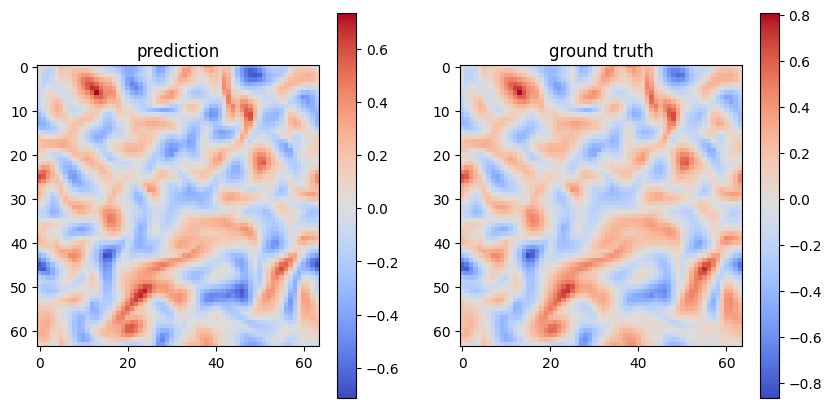

In [149]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.imshow(im_np, cmap="coolwarm")
plt.colorbar()
plt.title("prediction")

plt.subplot(1,2,2)
plt.imshow(gt, cmap="coolwarm")
plt.colorbar()
plt.title("ground truth")

8.177928


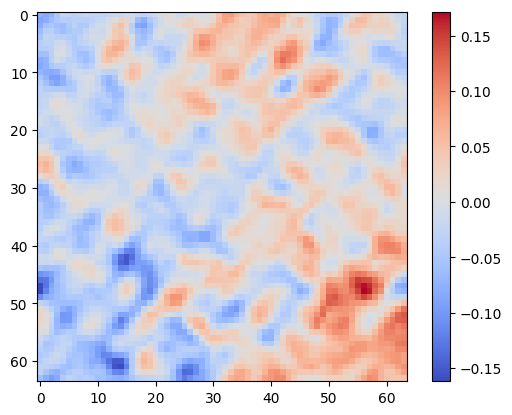

In [150]:
error = np.sum(np.power(gt - im_np, 2))
print(error)
err = gt - im_np
plt.imshow(err, cmap="coolwarm")
plt.colorbar()

Let's try to predict multiple frames

In [151]:
print(pos.shape)
print(fx.shape)

torch.Size([1, 4096, 2])
torch.Size([1, 4096, 10])


In [152]:
frame_number = 10

predictions = []

for f in range(frame_number):
    #predict
    print(f)
    im = model(pos, fx)
    im_np = im[0, :, 0].reshape(64, 64).detach().cpu().numpy()
    fx = torch.cat((fx[..., 1:], im), dim=-1)
    predictions.append(im_np)

0
1
2
3
4
5
6
7
8
9


1
2
3
4
5
6
7
8
9


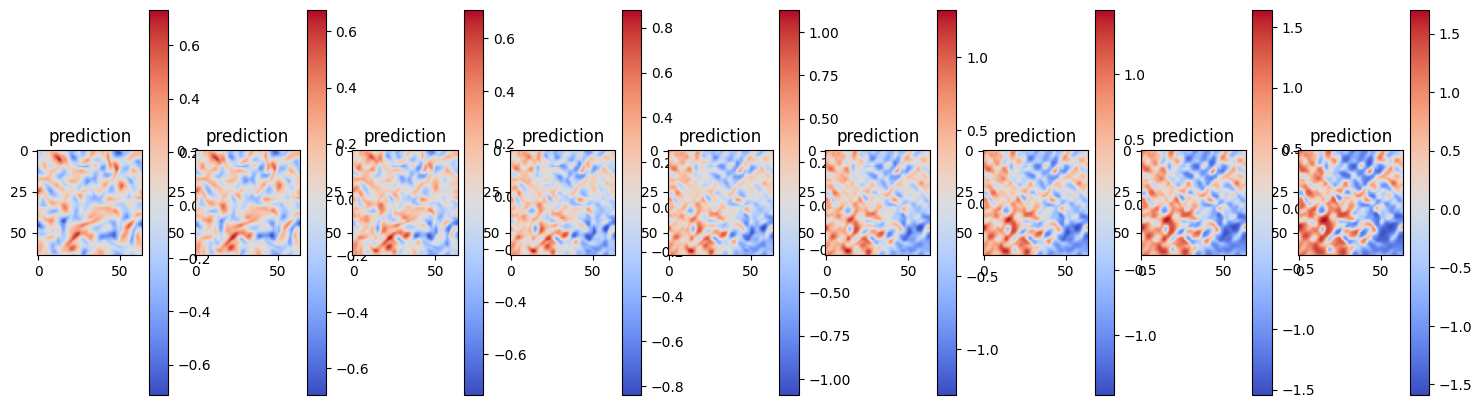

In [153]:
plt.figure(figsize=(20,5))

for i in range(1,frame_number):
    print(i)
    plt.subplot(1,frame_number,i)
    plt.imshow(predictions[i-1], cmap="coolwarm")
    plt.colorbar()
    plt.title("prediction")

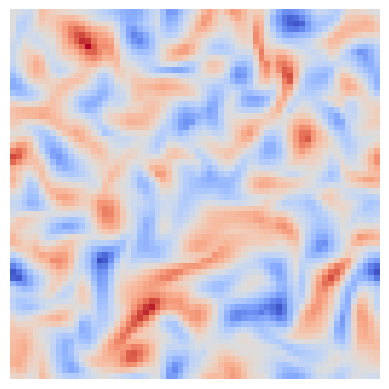

In [154]:
from matplotlib.animation import FuncAnimation

# Create a figure and axis
fig, ax = plt.subplots()
img = ax.imshow(predictions[0], cmap='coolwarm', interpolation='none')  # Initial frame
plt.axis('off')  # Optional: turn off the axis

# Function to update the frame
def update(frame):
    img.set_data(frame)  # Update the image data
    return [img]

# Create the animation
anim = FuncAnimation(fig, update, frames=predictions, interval=50, blit=True)  # interval in ms

# Show the animation
plt.show()

In [155]:
anim.save('animation_epoch2_T1.gif', writer='pillow')